# Entrainement des modèles de régression `sklearn`

**Objectif**

Entrainer un modèle de regréssion à predire les prix d'un type de bien choisi (appartements ou maison) pour une zone géographique donnée (Paris, Marseille, etc.).

**Données**

`DVF+` est une base de données construite à partir des bases de données `DVF` (Demandes de Valeurs Foncières) & `BNB` (Base Nationale des Bâtiments). Cette base a été construite en utilisant les méthodes du module `preprocessing` de la librairie `lib`. 

**Méthode** 

1. Choix d'une zone géographique (`geo_area`) et d'une type de bien (`property_type`)

<br>

2. Préparation du jeu de donneés pour la modélisation 
    - Filtrage des données (nombre de pièces, surface habitable, surface terrain, prix/m²)
    - Application du logarithme à la variable `l_valeur_fonciere`
    - Ajout des variables de tendance des prix du marché: moyenne mobile avec lag de 1 jour appliquée à la variable `valeur_fonciere`
    - Création des dummies 
    - Suppression des variables ayant une proportion de donnnées manquantes trop élevée

<br>

3. Séparation des jeux de données d'entrainement & test
    - Ordonner les transactions par ordre chronologique
    - Les 80% premières transactions sont dans le jeu de données train
    - Les 20% suivantes sont dans le jeu de données test 

<br>

4. Sélection des variables 
    - Calcul de l'information mutuelle (MI) entre les variables explicatives et la cible (`valeur_fonciere` ou `l_valeur_fonciere`)
    - `RandomForestRegressor` pour récupérer l'importance des variables mesurée par la *Mean Decrease Gini* (MDG)
    - Sélection des variables dont l'importance (MI et/ou MDG) est supérieure à seuil prédéfini (ex: quantile d'ordre 75%) 

<br>

5. Entrainement de plusieurs régresseurs
    - A partir des features sélectionnées
    - `LinearRegression`, `DecisionTreeRegressor`, `XGBRegressor`, ... 
    - Diagnostic

<br>

6. Optimisation du type de modèle le + adapté à la prédiction
    - Via [`optuna`](https://optuna.org/)
    - Identification de la combinaison d'hyperparamètres optimales
    - Ré-entrainement du modèle sur le train set 
    - Sauvegarde du modèle et du nom des features

## Setup

In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from lib.enums import IDF

from lib.preprocessing.utils import get_na_proportion

from lib.dataset import (
    load_dvfplus, 
    prepare_dataset, 
    prepare_dummies, 
    temporal_train_test_split, 
    get_feature_vector, 
    get_target_vector, 
    compute_mutual_info, 
    compute_rf_importances, 
    select_important_features,
)

from lib.dataset.build import (
    add_distance_to_transportation, 
    add_public_facilities, 
    add_distance_to_parks, 
)

from lib.dataset.utils import (
    get_categorical_vars, 
    get_most_frequent_levels,
    transform_price, 
    scale_features, 
    is_numeric
)

from lib.model import (
    CustomRegressor, 
    compute_metrics, 
    display_regression_report, 
    plot_predictions, 
    get_predictions, 
)

from lib.model.optimize import optuna_objective, OptimPruner

from lib.model.loader import save_model, load_model

In [4]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import rich 
from tqdm import tqdm

from multiprocessing import cpu_count

In [5]:
# preprocessing
from sklearn.preprocessing import MinMaxScaler

# estimators
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR

from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.neural_network import MLPRegressor

# optimization 
import optuna

In [6]:
# garbage collector
import gc
gc.collect()

0

In [7]:
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None

In [8]:
DATA_DIR = "../data/"
BACKUP_DIR = "../backup/"

CPU_COUNT = cpu_count()

## Data

### Import

In [52]:
df_args = {
    "geo_area": "urban_areas", 
    "region": None, 
    "departement": None,
    "property_type": "flats"
}

df = load_dvfplus(
    zip_dir=DATA_DIR, 
    zip_name="dvf+",
    property_type=df_args["property_type"], 
    geo_area=df_args["geo_area"])

C:\Users\pemma\AppData\Local\Temp/ipykernel_6992/2650997231.py:8: DtypeWarning: Columns (10,12,14,16,18,20,22,24,35,36,51) have mixed types.Specify dtype option on import or set low_memory=False.
  df = load_dvfplus(


In [53]:
# add features related to transportation and public facilities 

if df_args["geo_area"] == "Paris":

    transportation = pd.read_csv(f"{DATA_DIR}other/transportation.csv")
    parks = pd.read_csv(f"{DATA_DIR}other/parks.csv")
    facilities = pd.read_csv(f"{DATA_DIR}other/facilities.csv") 

    df = add_distance_to_transportation(df, transportation)
    del transportation

    df = add_distance_to_parks(df, parks)
    del parks 

    df = add_public_facilities(df, facilities)
    del facilities

elif df_args["geo_area"] == "urban_areas":

    if df_args["region"] is not None:
        df = df.loc[df.nom_region==df_args["region"], :]
        
    if df_args["departement"] is not None:
        df = df.loc[df.nom_departement==df_args["departement"], :]

In [54]:
df.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,dependance,code_region,nom_departement,nom_region,degre_densite,pop,annee,trimestre,mois,jour,parcelle_id,code_iris,periode_construction,periode_construction_max,hauteur_mean,altitude_sol_mean,conso_ener_mean,estim_ges_mean,conso_ener_std,estim_ges_std,conso_ener_min,estim_ges_min,conso_ener_max,estim_ges_max,ratio_ges_conso,enr_solaire_photovoltaique,enr_solaire_thermique_(chauffage)solaire_thermique_(ecs),enr_solaire_thermique_(ecs+chauffage),baie_u,mur_u_ext,pb_u,ph_u,mur_pos_isol_ext,prc_s_vitree_ext,presence_balcon,presence_climatisation,baie_orientation_indetermine,baie_orientation_nord,baie_orientation_ouest,baie_orientation_est,baie_orientation_horizontale,baie_orientation_est_ou_ouest,baie_orientation_sud,distance_batiment_historique_plus_proche,qpv,nb_lot_garpark,nb_lot_tot,nb_log,nb_lot_tertiaire,alea_argiles,alea_radon
0,2017-2,2017-07-06,1,Vente,59000.0,2.0,NaN,RUE GOUNOD,1720,1000.0,1053,Bourg-en-Bresse,1,NaN,NaN,01053000AL0175,NaN,NaN,45.0,32.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,32.0,1.0,NaN,NaN,NaN,NaN,NaN,5.219932,46.196098,1,84,Ain,Auvergne-Rhône-Alpes,Centres urbains intermédiaires,41111.0,2017,3,7,6,01053000AL0175,10530301.0,1989-1999,DE_1975_A_1993,11.0,242.0,264.8,11.7,38.6,2.8,215.0,8.0,372.1,19.0,0.04,0.0,0.0,0.0,2.2,0.45,2.0,2.5,ITI,0.198,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0,28.0,56.00,28.0,0.0,Faible,Faible
1,2017-5,2017-07-03,1,Vente,145650.0,3.0,B,RUE DE LA PREVOYANCE,3220,1000.0,1053,Bourg-en-Bresse,1,NaN,NaN,01053000AP0316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,Appartement,72.0,3.0,S,sols,NaN,NaN,165.0,5.225402,46.193041,0,84,Ain,Auvergne-Rhône-Alpes,Centres urbains intermédiaires,41111.0,2017,3,7,3,01053000AP0316,10530401.0,NaN,NaN,6.0,238.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,Moyen,Faible
2,2017-18,2017-07-11,1,Vente,119000.0,4.0,NaN,AV LOUIS JOURDAN,2350,1000.0,1053,Bourg-en-Bresse,1,NaN,NaN,01053000AD0479,NaN,NaN,110.0,NaN,121.0,NaN,124.0,NaN,NaN,NaN,NaN,NaN,3,2.0,Appartement,92.0,4.0,NaN,NaN,NaN,NaN,NaN,5.221009,46.203445,1,84,Ain,Auvergne-Rhône-Alpes,Centres urbains intermédiaires,41111.0,2017,3,7,11,01053000AD0479,10530103.0,1949-1970,NaN,11.0,236.0,212.5,32.4,56.4,23.2,149.0,8.0,257.0,54.2,0.23,0.0,0.0,0.0,4.0,1.90,2.0,1.2,non isole,0.525,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,209.0,0.0,0.0,76.00,76.0,0.0,Faible,Faible
3,2017-43,2017-07-12,1,Vente,68000.0,264.0,NaN,RUE LAMARTINE,0200,1000.0,1344,Saint-Denis-lès-Bourg,1,NaN,NaN,01344000AH0137,NaN,NaN,38.0,NaN,49.0,43.29,51.0,NaN,NaN,NaN,NaN,NaN,3,2.0,Appartement,42.0,2.0,NaN,NaN,NaN,NaN,NaN,5.203737,46.203785,1,84,Ain,Auvergne-Rhône-Alpes,Centres urbains intermédiaires,5943.0,2017,3,7,12,01344000AH0137,13440000.0,1949-1970,DE_1961_A_1974,8.0,239.0,348.4,63.7,62.9,42.2,299.6,16.6,419.4,98.2,0.23,0.0,0.0,0.0,2.2,0.98,2.0,2.5,ITI,0.482,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,0.0,9.0,25.50,7.5,0.0,Faible,Faible
4,2017-49,2017-07-03,1,Vente,116000.0,1.0,NaN,PL DE LA BASILIQUE,0350,1000.0,1053,Bourg-en-Bresse,1,NaN,NaN,01053000AN0111,NaN,NaN,1.0,76.09,16.0,NaN,24.0,NaN,NaN,NaN,NaN,NaN,3,2.0,Appartement,76.0,3.0,NaN,NaN,NaN,NaN,NaN,5.222424,46.199016,0,84,Ain,Auvergne-Rhône-Alpes,Centres urbains intermédiaires,41111.0,2017,3,7,3,01053000AN0111,10530301.0,<1948,NaN,12.0,236.0,242.5,

In [12]:
df.shape

(33696, 91)

### Exploration 

L'objectif est de représenter les variables `valeur_fonciere`, `nombre_pieces_principales`, `surface_reelle_bati` et `surface_terrain` pour déterminer ensuite des filtres à appliquer aux données. 

In [55]:
tmp = df.copy()

tmp["valeur_fonciere_m2"] = tmp.apply(
    lambda row: transform_price(row.valeur_fonciere, log=False, area=row.surface_reelle_bati), 
    axis=1
)

Quelques statistiques descriptives relatives aux variables quantitatives qui décrivent les biens. Ces résultats sont utiles pour identifier les valeurs aberrantes et déterminer des seuils. 

In [56]:
vars = ["valeur_fonciere_m2", "surface_reelle_bati", "surface_terrain"]
summary = tmp[vars].describe(percentiles=[.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
summary 

,valeur_fonciere_m2,surface_reelle_bati,surface_terrain
count,1.225375e+06,1.225813e+06,10733.000000
mean,3.232782e+03,5.987565e+01,753.346688
std,5.053946e+03,2.687314e+01,3331.276890
min,1.785714e-03,1.000000e+00,1.000000
1%,5.156250e+02,1.700000e+01,14.000000
5%,9.354839e+02,2.300000e+01,29.000000
10%,1.188679e+03,2.800000e+01,46.000000
25%,1.772727e+03,4.200000e+01,88.000000
50%,2.682927e+03,5.900000e+01,196.000000
75%,3.990303e+03,7.400000e+01,465.000000


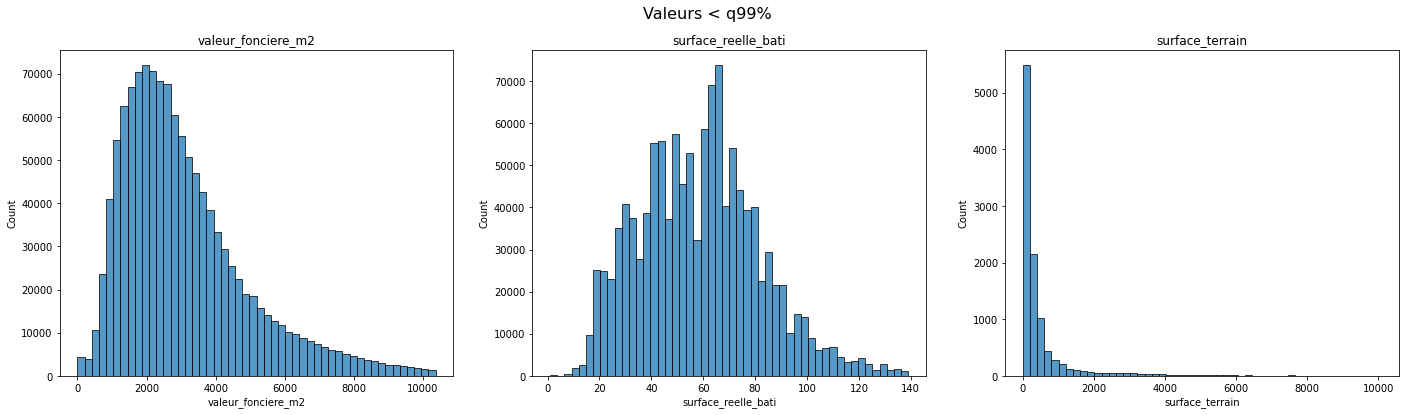

In [57]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 6))
fig.suptitle("Valeurs < q99%", fontsize=16)

for var, ax in zip(vars, axes.flatten()): 
    thresold = summary[var]["99%"]

    x = tmp.loc[tmp[var] < thresold, var].dropna()
    sns.histplot(x, ax=ax, bins=50)
    ax.set_title(var);

In [58]:
for var in vars: 
    na_prop = get_na_proportion(tmp, var)
    print(f"{var}: {round(100 * na_prop, 3)}% valeurs manquantes")

valeur_fonciere_m2: 0.037% valeurs manquantes
surface_reelle_bati: 0.001% valeurs manquantes
surface_terrain: 99.124% valeurs manquantes


In [59]:
tmp\
    .nombre_pieces_principales\
    .value_counts(dropna=False, normalize=True)\
    .reset_index()\
    .rename(columns={"index": "nombre_pieces_principales", "nombre_pieces_principales": "proportion"})

,nombre_pieces_principales,proportion
0,3.0,3.232612e-01
1,2.0,2.827285e-01
2,4.0,1.915174e-01
3,1.0,1.459457e-01
4,5.0,4.688757e-02
5,6.0,6.906364e-03
6,7.0,1.356636e-03
7,0.0,7.358304e-04
8,8.0,3.695467e-04
9,9.0,1.329716e-04


In [60]:
del tmp 

### Préparation du dataset

Application des filtres statiques sur les variables qui décrivent le bien via le dictionnaire `numeric_filters` : 
- nombre de pièces principales
- surface du bien
- valeur foncière/m² (cf: [meilleursagents](https://www.meilleursagents.com/prix-immobilier/)) 
- surface du terrain (pour les maisons)

Le paramètre `na_thresold` indique la proportion maximale de données manquantes que l'on autorise pour appliquer les techniques d'imputation (par la médiane pour les valeurs numériques, par le mode pour les catégorielles). Les colonnes ayant une proportion de donnnées manquantes supérieures à `na_thresold` sont supprimées. 

Les paramètres de `mov_av_windows` sont utilisées pour calculer les moyennes mobiles du prix moyen journalier ($\approx$ prix du marché à court/moyen/long terme). Notons que l'on applique un lag de 1 jour puisqu'il est nécessaire d'utiliser le prix du marché à la date $t-1$ pour expliquer le prix du bien vendu à la date $t$. Lorsque le paramètre `neighborhood_var` est renseignée, on calcule le prix du marché à court/moyen/long terme par quartier dans la base étudiée. Un quartier peut être un arrondissement, une commune ou un département. 

In [19]:
preproc_args = {

    "numeric_filters": {
        "nombre_pieces_principales": (2, 5),
        "surface_reelle_bati": (18, 120), 
        # "surface_terrain": (80, 1200), 
        "valeur_fonciere_m2": (1000, 7000)
    },  

    "na_threshold": 0.5,

    "mov_av_windows": [7, 14, 30, 90], 

    "neighborhood_var": "nom_commune"
    
}

df_preproc, dvf_vars, bnb_vars, other_vars = prepare_dataset(df, target_var="l_valeur_fonciere", **preproc_args)

Preprocessing summary:

{
    'created': [
        'l_valeur_fonciere',
        'l_surface_reelle_bati',
        'l_hauteur_mean',
        'l_altitude_sol_mean',
        'l_conso_ener_mean',
        'l_estim_ges_mean',
        'l_conso_ener_std',
        'l_estim_ges_std',
        'l_conso_ener_min',
        'l_estim_ges_min',
        'l_conso_ener_max',
        'l_estim_ges_max',
        'l_ratio_ges_conso',
        'l_baie_u',
        'l_mur_u_ext',
        'l_pb_u',
        'l_ph_u',
        'l_prc_s_vitree_ext',
        'valeur_fonciere_m2',
        'l_valeur_fonciere_ma7',
        'l_valeur_fonciere_ma14',
        'l_valeur_fonciere_ma30',
        'l_valeur_fonciere_ma90'
    ],
    'removed': ['surface_terrain', 'distance_batiment_historique_plus_proche']
}

In [20]:
df_preproc.head()

,id_mutation,date_mutation,valeur_fonciere,nom_commune,surface_reelle_bati,nombre_pieces_principales,dependance,nom_departement,trimestre,mois,periode_construction,periode_construction_max,hauteur_mean,altitude_sol_mean,conso_ener_mean,estim_ges_mean,conso_ener_std,estim_ges_std,conso_ener_min,estim_ges_min,conso_ener_max,estim_ges_max,ratio_ges_conso,enr_solaire_photovoltaique,enr_solaire_thermique_(chauffage)solaire_thermique_(ecs),enr_solaire_thermique_(ecs+chauffage),baie_u,mur_u_ext,pb_u,ph_u,mur_pos_isol_ext,prc_s_vitree_ext,presence_balcon,presence_climatisation,baie_orientation_indetermine,baie_orientation_nord,baie_orientation_ouest,baie_orientation_est,baie_orientation_horizontale,baie_orientation_est_ou_ouest,baie_orientation_sud,qpv,nb_lot_garpark,nb_lot_tot,nb_log,nb_lot_tertiaire,alea_argiles,alea_radon,l_valeur_fonciere,l_surface_reelle_bati,l_hauteur_mean,l_altitude_sol_mean,l_conso_ener_mean,l_estim_ges_mean,l_conso_ener_std,l_estim_ges_std,l_conso_ener_min,l_estim_ges_min,l_conso_ener_max,l_estim_ges_max,l_ratio_ges_conso,l_baie_u,l_mur_u_ext,l_pb_u,l_ph_u,l_prc_s_vitree_ext,valeur_fonciere_m2,l_valeur_fonciere_ma7,l_valeur_fonciere_ma14,l_valeur_fonciere_ma30,l_valeur_fonciere_ma90
0,2017-554687,2017-07-04,145000.0,Brie-Comte-Robert,41.0,2,1,Seine-et-Marne,3,7,<1948,DE_1975_A_1993,10.0,79.0,235.8,16.8,52.7,5.8,162.1,9.4,322.5,28.0,0.05,0.0,0.0,0.0,2.3,0.43,1.45,1.2,ITI,0.254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,89.0,36.5,0.0,Moyen,Faible,11.884489,3.713572,2.302585,4.369448,5.462984,2.821379,3.964615,1.757858,5.088213,2.240710,5.776103,3.332205,-2.995732,0.832909,-0.843970,0.371564,0.182322,-1.370421,3536.585366,NaN,NaN,NaN,NaN
1,2017-554690,2017-07-05,145000.0,Brie-Comte-Robert,42.0,2,1,Seine-et-Marne,3,7,<1948,DE_1975_A_1993,10.0,79.0,235.8,16.8,52.7,5.8,162.1,9.4,322.5,28.0,0.05,0.0,0.0,0.0,2.3,0.43,1.45,1.2,ITI,0.254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,89.0,36.5,0.0,Moyen,Faible,11.884489,3.737670,2.302585,4.369448,5.462984,2.821379,3.964615,1.757858,5.088213,2.240710,5.776103,3.332205,-2.995732,0.832909,-0.843970,0.371564,0.182322,-1.370421,3452.380952,NaN,NaN,NaN,NaN
2,2017-554698,2017-07-03,127000.0,Savigny-le-Temple,77.0,4,1,Seine-et-Marne,3,7,<1948,DE_1975_A_1993,10.0,79.0,235.8,16.8,52.7,5.8,162.1,9.4,322.5,28.0,0.05,0.0,0.0,0.0,2.3,0.43,1.45,1.2,ITI,0.254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,89.0,36.5,0.0,Moyen,Faible,11.751942,4.343805,2.302585,4.369448,5.462984,2.821379,3.964615,1.757858,5.088213,2.240710,5.776103,3.332205,-2.995732,0.832909,-0.843970,0.371564,0.182322,-1.370421,1649.350649,NaN,NaN,NaN,NaN
3,2017-554702,2017-07-06,159000.0,Lieusaint,51.0,2,1,Seine-et-Marne,3,7,2006-2012,DE_2001_A_2010,6.0,85.0,213.7,10.3,34.6,2.2,171.0,8.0,274.0,15.0,0.05,0.0,0.0,0.0,2.2,0.36,0.27,0.2,ITI,0.174,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,108.0,213.0,81.0,0.0,Moyen,Faible,11.976659,3.931826,1.791759,4.442651,5.364573,2.332144,3.543854,0.788457,5.141664,2.079442,5.613128,2.708050,-2.995732,0.788457,-1.021651,-1.309333,-1.609438,-1.748700,3117.647059,NaN,NaN,NaN,NaN
4,2017-554706,2017-07-05,133000.0,Melun,66.0,4,1,Seine-et-Marne,3,7,<1948,DE_1975_A_1993,3.0,73.0,235.8,16.8,52.7,5.8,162.1,9.4,322.5,28.0,0.05,0.0,0.0,0.0,2.3,0.43,1.45,1.2,ITI,0.254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,89.0,36.5,0.0,Moyen,Faible,11.798104,4.189655,1.098612,4.290459,5.462984,2.821379,3.964615,1.757858,5.088213,2.240710,5.776103,3.332205,-2.995732,0.832909,-0.843970,0.371564,0.182322,-1.370421,2015.151515,NaN,NaN,NaN,NaN


### Encodage des dummies

Cette section permet de transformer les variables catégorielles en variables binaires. Pour chaque variable, la catégorie de référence correspond à la plus fréquente dans le jeu de données. Cette catégorie de référence est ensuite supprimée afin d'éviter tout problème de multicolinéarité dans la matrice des variables explicatives. 

In [21]:
# categorical variable = pandas column with <= 30 unique values

categorical_vars = get_categorical_vars(df_preproc, n_levels_max=30)   
categorical_vars.append("baie_orientation")

categorical_vars

['nombre_pieces_principales',
 'nom_departement',
 'trimestre',
 'mois',
 'periode_construction',
 'periode_construction_max',
 'mur_pos_isol_ext',
 'alea_argiles',
 'alea_radon',
 'baie_orientation']

In [22]:
# select most representative levels for each categorical variable
dummy_ref_levels = get_most_frequent_levels(df_preproc, categorical_vars)
dummy_ref_levels

{'baie_orientation': 'nord',
 'nombre_pieces_principales': '3',
 'nom_departement': 'Seine-et-Marne',
 'trimestre': '3',
 'mois': '7',
 'periode_construction': '<1948',
 'periode_construction_max': 'DE_1975_A_1993',
 'mur_pos_isol_ext': 'ITI',
 'alea_argiles': 'Moyen',
 'alea_radon': 'Faible'}

In [23]:
df_preproc, dvf_vars, bnb_vars, other_vars = prepare_dummies(
    df_preproc, 
    categorical_vars, 
    dummy_ref_levels, 
    dvf_vars, 
    bnb_vars, 
    other_vars)

Preprocessing summary:

{
    'created': [
        'nombre_pieces_principales_2',
        'nombre_pieces_principales_5',
        'mois_1',
        'mois_9',
        'nombre_pieces_principales_3',
        'mois_5',
        'mois_11',
        'trimestre_3',
        'mois_6',
        'nombre_pieces_principales_4',
        'mois_8',
        'trimestre_4',
        'trimestre_1',
        'mois_2',
        'trimestre_2',
        'nom_departement_Seine-et-Marne',
        'mois_10',
        'mois_3',
        'mois_12',
        'mois_7',
        'mois_4',
        'periode_construction_2006-2012',
        'mur_pos_isol_ext_ITR',
        'periode_construction_max_DE_1994_A_2000',
        'periode_construction_max_APRES_2011',
        'periode_construction_1949-1970',
        'periode_construction_1989-1999',
        'periode_construction_max_DE_1961_A_1974',
        'periode_construction_max_AVANT_1949',
        'mur_pos_isol_ext_ITI',
        'periode_construction_max_non renseigné',
        'periode_construction_bad sup',
        'periode_construction_max_DE_1949_A_1960',
        'periode_construction_2000-2005',
        'mur_pos_isol_ext_ITE',
        'alea_radon_Faible',
        'alea_argiles_Moyen',
        'periode_construction_bad inf',
        'periode_construction_1970-1988',
        'mur_pos_isol_ext_isole',
        'mur_pos_isol_ext_ITI+ITR',
        'alea_argiles_Fort',
        'periode_construction_max_DE_2001_A_2010',
        'periode_construction_<1948',
        'periode_construction_max_DE_1975_A_1993',
        'mur_pos_isol_ext_ITI+ITE',
        'periode_construction_>2012',
        'mur_pos_isol_ext_non isole',
        'mur_pos_isol_ext_ITE+ITR'
    ],
    'removed': [
        'baie_orientation_nord',
        'nombre_pieces_principales_3',
        'nom_departement_Seine-et-Marne',
        'trimestre_3',
        'mois_7',
        'periode_construction_<1948',
        'periode_construction_max_DE_1975_A_1993',
        'mur_pos_isol_ext_ITI',
        'alea_argiles_Moyen',
        'alea_radon_Faible',
        'enr_solaire_thermique_(chauffage)solaire_thermique_(ecs)',
        'enr_solaire_thermique_(ecs+chauffage)'
    ]
}

In [24]:
# set id_mutation as index 

df_preproc.set_index("id_mutation", inplace=True)

In [25]:
df_preproc.head()

,date_mutation,valeur_fonciere,nom_commune,surface_reelle_bati,dependance,hauteur_mean,altitude_sol_mean,conso_ener_mean,estim_ges_mean,conso_ener_std,estim_ges_std,conso_ener_min,estim_ges_min,conso_ener_max,estim_ges_max,ratio_ges_conso,enr_solaire_photovoltaique,baie_u,mur_u_ext,pb_u,ph_u,prc_s_vitree_ext,presence_balcon,presence_climatisation,baie_orientation_indetermine,baie_orientation_ouest,baie_orientation_est,baie_orientation_horizontale,baie_orientation_est_ou_ouest,baie_orientation_sud,qpv,nb_lot_garpark,nb_lot_tot,nb_log,nb_lot_tertiaire,l_valeur_fonciere,l_surface_reelle_bati,l_hauteur_mean,l_altitude_sol_mean,l_conso_ener_mean,l_estim_ges_mean,l_conso_ener_std,l_estim_ges_std,l_conso_ener_min,l_estim_ges_min,l_conso_ener_max,l_estim_ges_max,l_ratio_ges_conso,l_baie_u,l_mur_u_ext,l_pb_u,l_ph_u,l_prc_s_vitree_ext,valeur_fonciere_m2,l_valeur_fonciere_ma7,l_valeur_fonciere_ma14,l_valeur_fonciere_ma30,l_valeur_fonciere_ma90,nombre_pieces_principales_2,nombre_pieces_principales_4,nombre_pieces_principales_5,trimestre_1,trimestre_2,trimestre_4,mois_1,mois_10,mois_11,mois_12,mois_2,mois_3,mois_4,mois_5,mois_6,mois_8,mois_9,periode_construction_1949-1970,periode_construction_1970-1988,periode_construction_1989-1999,periode_construction_2000-2005,periode_construction_2006-2012,periode_construction_>2012,periode_construction_bad inf,periode_construction_bad sup,periode_construction_max_APRES_2011,periode_construction_max_AVANT_1949,periode_construction_max_DE_1949_A_1960,periode_construction_max_DE_1961_A_1974,periode_construction_max_DE_1994_A_2000,periode_construction_max_DE_2001_A_2010,periode_construction_max_non renseigné,mur_pos_isol_ext_ITE,mur_pos_isol_ext_ITE+ITR,mur_pos_isol_ext_ITI+ITE,mur_pos_isol_ext_ITI+ITR,mur_pos_isol_ext_ITR,mur_pos_isol_ext_isole,mur_pos_isol_ext_non isole,alea_argiles_Fort
id_mutation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-554687,2017-07-04,145000.0,Brie-Comte-Robert,41.0,1,10.0,79.0,235.8,16.8,52.7,5.8,162.1,9.4,322.5,28.0,0.05,0.0,2.3,0.43,1.45,1.2,0.254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,89.0,36.5,0.0,11.884489,3.713572,2.302585,4.369448,5.462984,2.821379,3.964615,1.757858,5.088213,2.240710,5.776103,3.332205,-2.995732,0.832909,-0.843970,0.371564,0.182322,-1.370421,3536.585366,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-554690,2017-07-05,145000.0,Brie-Comte-Robert,42.0,1,10.0,79.0,235.8,16.8,52.7,5.8,162.1,9.4,322.5,28.0,0.05,0.0,2.3,0.43,1.45,1.2,0.254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,89.0,36.5,0.0,11.884489,3.737670,2.302585,4.369448,5.462984,2.821379,3.964615,1.757858,5.088213,2.240710,5.776103,3.332205,-2.995732,0.832909,-0.843970,0.371564,0.182322,-1.370421,3452.380952,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-554698,2017-07-03,127000.0,Savigny-le-Temple,77.0,1,10.0,79.0,235.8,16.8,52.7,5.8,162.1,9.4,322.5,28.0,0.05,0.0,2.3,0.43,1.45,1.2,0.254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,89.0,36.5,0.0,11.751942,4.343805,2.302585,4.369448,5.462984,2.821379,3.964615,1.757858,5.088213,2.240710,5.776103,3.332205,-2.995732,0.832909,-0.843970,0.371564,0.182322,-1.370421,1649.350649,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-554702,2017-07-06,159000.0,Lieusaint,51.0,1,6.0,85.0,213.7,10.3,34.6,2.2,171.0,8.0,274.0,15.0,0.05,0.0,2.2,0.36,0.27,0.2,0.174,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,108.0,213.0,81.0,0.0,11.976659,3.931826,1.791759,4.442651,5.364573,2.332144,3.543854,0.788457,5.141664,2.079442,5.613128,2.708050,-2.995732,0.788457,-1.021651,-1.309333,-1.609438,-1.748700,3117.647059,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2017-554706,2017-07-05,133000.0,Melun,66.0,1,3.0,73.0,235.8,16.8,52.7,5.8,162.1,9.4,322.5,28.0,0.05,0.0,2.3,0.43,1.45,1.2,0.254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,89.

In [26]:
rich.print(list(df_preproc.columns)) 

[
    'date_mutation',
    'valeur_fonciere',
    'nom_commune',
    'surface_reelle_bati',
    'dependance',
    'hauteur_mean',
    'altitude_sol_mean',
    'conso_ener_mean',
    'estim_ges_mean',
    'conso_ener_std',
    'estim_ges_std',
    'conso_ener_min',
    'estim_ges_min',
    'conso_ener_max',
    'estim_ges_max',
    'ratio_ges_conso',
    'enr_solaire_photovoltaique',
    'baie_u',
    'mur_u_ext',
    'pb_u',
    'ph_u',
    'prc_s_vitree_ext',
    'presence_balcon',
    'presence_climatisation',
    'baie_orientation_indetermine',
    'baie_orientation_ouest',
    'baie_orientation_est',
    'baie_orientation_horizontale',
    'baie_orientation_est_ou_ouest',
    'baie_orientation_sud',
    'qpv',
    'nb_lot_garpark',
    'nb_lot_tot',
    'nb_log',
    'nb_lot_tertiaire',
    'l_valeur_fonciere',
    'l_surface_reelle_bati',
    'l_hauteur_mean',
    'l_altitude_sol_mean',
    'l_conso_ener_mean',
    'l_estim_ges_mean',
    'l_conso_ener_std',
    'l_estim_ges_std',
    'l_conso_ener_min',
    'l_estim_ges_min',
    'l_conso_ener_max',
    'l_estim_ges_max',
    'l_ratio_ges_conso',
    'l_baie_u',
    'l_mur_u_ext',
    'l_pb_u',
    'l_ph_u',
    'l_prc_s_vitree_ext',
    'valeur_fonciere_m2',
    'l_valeur_fonciere_ma7',
    'l_valeur_fonciere_ma14',
    'l_valeur_fonciere_ma30',
    'l_valeur_fonciere_ma90',
    'nombre_pieces_principales_2',
    'nombre_pieces_principales_4',
    'nombre_pieces_principales_5',
    'trimestre_1',
    'trimestre_2',
    'trimestre_4',
    'mois_1',
    'mois_10',
    'mois_11',
    'mois_12',
    'mois_2',
    'mois_3',
    'mois_4',
    'mois_5',
    'mois_6',
    'mois_8',
    'mois_9',
    'periode_construction_1949-1970',
    'periode_construction_1970-1988',
    'periode_construction_1989-1999',
    'periode_construction_2000-2005',
    'periode_construction_2006-2012',
    'periode_construction_>2012',
    'periode_construction_bad inf',
    'periode_construction_bad sup',
    'periode_construction_max_APRES_2011',
    'periode_construction_max_AVANT_1949',
    'periode_construction_max_DE_1949_A_1960',
    'periode_construction_max_DE_1961_A_1974',
    'periode_construction_max_DE_1994_A_2000',
    'periode_construction_max_DE_2001_A_2010',
    'periode_construction_max_non renseigné',
    'mur_pos_isol_ext_ITE',
    'mur_pos_isol_ext_ITE+ITR',
    'mur_pos_isol_ext_ITI+ITE',
    'mur_pos_isol_ext_ITI+ITR',
    'mur_pos_isol_ext_ITR',
    'mur_pos_isol_ext_isole',
    'mur_pos_isol_ext_non isole',
    'alea_argiles_Fort'
]

La variable cible `l_valeur_fonciere` correspond au logarithme du prix de ventes des biens (`valeur_fonciere`). On décide alors d'exprimer les variables numériques continues sur une échelle logarithmique pour minimiser les effets d'échelle de ces variables. Notons que l'on n'applique pas la transformation logarithmique aux variables numériques discrètes. 

In [27]:
# remove continuous variables which have a counterpart expressed in log scale

to_remove = [
    'valeur_fonciere',
    'valeur_fonciere_m2', 
    'surface_reelle_bati',
    'surface_terrain', 
    'hauteur_mean',
    'altitude_sol_mean',
    'conso_ener_mean',
    'estim_ges_mean',
    'conso_ener_std',
    'estim_ges_std',
    'conso_ener_min',
    'estim_ges_min',
    'conso_ener_max',
    'estim_ges_max',
    'ratio_ges_conso',
    'distance_transport', 
    'distance_park', 
    'distance_batiment_historique_plus_proche', 
    'nom_commune',
]

to_remove = [col for col in to_remove if col in df_preproc.columns]

df_preproc.drop(labels=to_remove, axis=1, inplace=True)

In [28]:
df_preproc.head()

,date_mutation,dependance,enr_solaire_photovoltaique,baie_u,mur_u_ext,pb_u,ph_u,prc_s_vitree_ext,presence_balcon,presence_climatisation,baie_orientation_indetermine,baie_orientation_ouest,baie_orientation_est,baie_orientation_horizontale,baie_orientation_est_ou_ouest,baie_orientation_sud,qpv,nb_lot_garpark,nb_lot_tot,nb_log,nb_lot_tertiaire,l_valeur_fonciere,l_surface_reelle_bati,l_hauteur_mean,l_altitude_sol_mean,l_conso_ener_mean,l_estim_ges_mean,l_conso_ener_std,l_estim_ges_std,l_conso_ener_min,l_estim_ges_min,l_conso_ener_max,l_estim_ges_max,l_ratio_ges_conso,l_baie_u,l_mur_u_ext,l_pb_u,l_ph_u,l_prc_s_vitree_ext,l_valeur_fonciere_ma7,l_valeur_fonciere_ma14,l_valeur_fonciere_ma30,l_valeur_fonciere_ma90,nombre_pieces_principales_2,nombre_pieces_principales_4,nombre_pieces_principales_5,trimestre_1,trimestre_2,trimestre_4,mois_1,mois_10,mois_11,mois_12,mois_2,mois_3,mois_4,mois_5,mois_6,mois_8,mois_9,periode_construction_1949-1970,periode_construction_1970-1988,periode_construction_1989-1999,periode_construction_2000-2005,periode_construction_2006-2012,periode_construction_>2012,periode_construction_bad inf,periode_construction_bad sup,periode_construction_max_APRES_2011,periode_construction_max_AVANT_1949,periode_construction_max_DE_1949_A_1960,periode_construction_max_DE_1961_A_1974,periode_construction_max_DE_1994_A_2000,periode_construction_max_DE_2001_A_2010,periode_construction_max_non renseigné,mur_pos_isol_ext_ITE,mur_pos_isol_ext_ITE+ITR,mur_pos_isol_ext_ITI+ITE,mur_pos_isol_ext_ITI+ITR,mur_pos_isol_ext_ITR,mur_pos_isol_ext_isole,mur_pos_isol_ext_non isole,alea_argiles_Fort
id_mutation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-554687,2017-07-04,1,0.0,2.3,0.43,1.45,1.2,0.254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,89.0,36.5,0.0,11.884489,3.713572,2.302585,4.369448,5.462984,2.821379,3.964615,1.757858,5.088213,2.240710,5.776103,3.332205,-2.995732,0.832909,-0.843970,0.371564,0.182322,-1.370421,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-554690,2017-07-05,1,0.0,2.3,0.43,1.45,1.2,0.254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,89.0,36.5,0.0,11.884489,3.737670,2.302585,4.369448,5.462984,2.821379,3.964615,1.757858,5.088213,2.240710,5.776103,3.332205,-2.995732,0.832909,-0.843970,0.371564,0.182322,-1.370421,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-554698,2017-07-03,1,0.0,2.3,0.43,1.45,1.2,0.254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,89.0,36.5,0.0,11.751942,4.343805,2.302585,4.369448,5.462984,2.821379,3.964615,1.757858,5.088213,2.240710,5.776103,3.332205,-2.995732,0.832909,-0.843970,0.371564,0.182322,-1.370421,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-554702,2017-07-06,1,0.0,2.2,0.36,0.27,0.2,0.174,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,108.0,213.0,81.0,0.0,11.976659,3.931826,1.791759,4.442651,5.364573,2.332144,3.543854,0.788457,5.141664,2.079442,5.613128,2.708050,-2.995732,0.788457,-1.021651,-1.309333,-1.609438,-1.748700,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2017-554706,2017-07-05,1,0.0,2.3,0.43,1.45,1.2,0.254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,89.0,36.5,0.0,11.798104,4.189655,1.098612,4.290459,5.462984,2.821379,3.964615,1.757858,5.088213,2.240710,5.776103,3.332205,-2.995732,0.832909,-0.843970,0.371564,0.182322,-1.370421,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
df_preproc.shape

(28103, 83)

### Train/test split 

Pour obtenir les jeux de données d'entrainement et de test, on applique une séparation temporelle selon la date de transaction (`date_mutation`). Cette méthode est nécessaire puisque la matrice des features comprend des variables représentant l'évolution du prix du marché à court/moyen/long terme (il s'agit des variables de la forme `valeur_fonciere_ma[ma_window]`). Les 80% premières transactions constituent l'échantillon d'entrainement et sont utilisées pour la recherche du meilleur modèle. Les 20% restantes sont utilisées pour tester la performance des modèles. 

In [30]:
df_train, df_test, train_dates, test_dates = temporal_train_test_split(df_preproc, date_var="date_mutation", train_prop=.8)

In [31]:
print(f"Période d'entrainement : {train_dates.min()} / {train_dates.max()}") 
print(f"Période de test : {test_dates.min()} / {test_dates.max()}") 

Période d'entrainement : 2017-07-01 / 2021-07-30
Période de test : 2021-07-30 / 2022-06-30


In [32]:
target = "l_valeur_fonciere"

X_tr, features = get_feature_vector(df_train, return_features=True, target=target, return_df=False)
y_tr = get_target_vector(df_train, target=target, return_series=False) 

X_te = get_feature_vector(df_test, target=target, return_df=False)
y_te = get_target_vector(df_test, target=target, return_series=False) 

In [33]:
print(f"{X_tr.shape[0]:,} exemples d'entrainement pour {X_tr.shape[1]} features.")
print(f"{X_te.shape[0]:,} exemples test.")

15,370 exemples d'entrainement pour 81 features.
5,113 exemples test.


In [34]:
rich.print(features)

[
    'dependance',
    'enr_solaire_photovoltaique',
    'baie_u',
    'mur_u_ext',
    'pb_u',
    'ph_u',
    'prc_s_vitree_ext',
    'presence_balcon',
    'presence_climatisation',
    'baie_orientation_indetermine',
    'baie_orientation_ouest',
    'baie_orientation_est',
    'baie_orientation_horizontale',
    'baie_orientation_est_ou_ouest',
    'baie_orientation_sud',
    'qpv',
    'nb_lot_garpark',
    'nb_lot_tot',
    'nb_log',
    'nb_lot_tertiaire',
    'l_surface_reelle_bati',
    'l_hauteur_mean',
    'l_altitude_sol_mean',
    'l_conso_ener_mean',
    'l_estim_ges_mean',
    'l_conso_ener_std',
    'l_estim_ges_std',
    'l_conso_ener_min',
    'l_estim_ges_min',
    'l_conso_ener_max',
    'l_estim_ges_max',
    'l_ratio_ges_conso',
    'l_baie_u',
    'l_mur_u_ext',
    'l_pb_u',
    'l_ph_u',
    'l_prc_s_vitree_ext',
    'l_valeur_fonciere_ma7',
    'l_valeur_fonciere_ma14',
    'l_valeur_fonciere_ma30',
    'l_valeur_fonciere_ma90',
    'nombre_pieces_principales_2',
    'nombre_pieces_principales_4',
    'nombre_pieces_principales_5',
    'trimestre_1',
    'trimestre_2',
    'trimestre_4',
    'mois_1',
    'mois_10',
    'mois_11',
    'mois_12',
    'mois_2',
    'mois_3',
    'mois_4',
    'mois_5',
    'mois_6',
    'mois_8',
    'mois_9',
    'periode_construction_1949-1970',
    'periode_construction_1970-1988',
    'periode_construction_1989-1999',
    'periode_construction_2000-2005',
    'periode_construction_2006-2012',
    'periode_construction_>2012',
    'periode_construction_bad inf',
    'periode_construction_bad sup',
    'periode_construction_max_APRES_2011',
    'periode_construction_max_AVANT_1949',
    'periode_construction_max_DE_1949_A_1960',
    'periode_construction_max_DE_1961_A_1974',
    'periode_construction_max_DE_1994_A_2000',
    'periode_construction_max_DE_2001_A_2010',
    'periode_construction_max_non renseigné',
    'mur_pos_isol_ext_ITE',
    'mur_pos_isol_ext_ITE+ITR',
    'mur_pos_isol_ext_ITI+ITE',
    'mur_pos_isol_ext_ITI+ITR',
    'mur_pos_isol_ext_ITR',
    'mur_pos_isol_ext_isole',
    'mur_pos_isol_ext_non isole',
    'alea_argiles_Fort'
]

## Feature selection 

On applique deux méthodes sur le jeu de données d'entrainement pour identifier les variables explicatives pouvant expliquer au mieux la valeur foncière des biens. 

La première méthode est l'**information mutuelle**. *Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. MI is based on the KL divergence.* On sélectionne ensuite les features ayant une MI supérieure à un certain seuil. 

La seconde méthode consiste à calculér la ***Mean Decrease Gini*** (MDG) à partir de l'estimateur `RandomForestRegressor` et de sélectionner les features ayant une MDG supérieure à certain seuil.  

### Fit

In [35]:
if len(X_tr) <= 150000:     
    # compute mutual information between features and target
    # if dataset is small enough
    mi_values = compute_mutual_info(X_tr, y_tr, features)

In [36]:
mdg_values = compute_rf_importances(X_tr, y_tr, features)

RandomForestRegressor fitted.
Train MAPE: 0.38%


### Evaluation

Une fois les métriques d'importance calculées, on définit des seuils pour la sélection des variables. Par exemple, si le seuil est fixé à `75%`, on sélectionne les variables dont l'importance est supérieure au 3ème quantile des valeurs d'importance. 

In [37]:
mi_threshold = "50%"
mdg_threshold = "75%"

important_features_mi = select_important_features(mi_values, threshold=mi_threshold)
important_features_mdg = select_important_features(mdg_values, threshold=mdg_threshold)

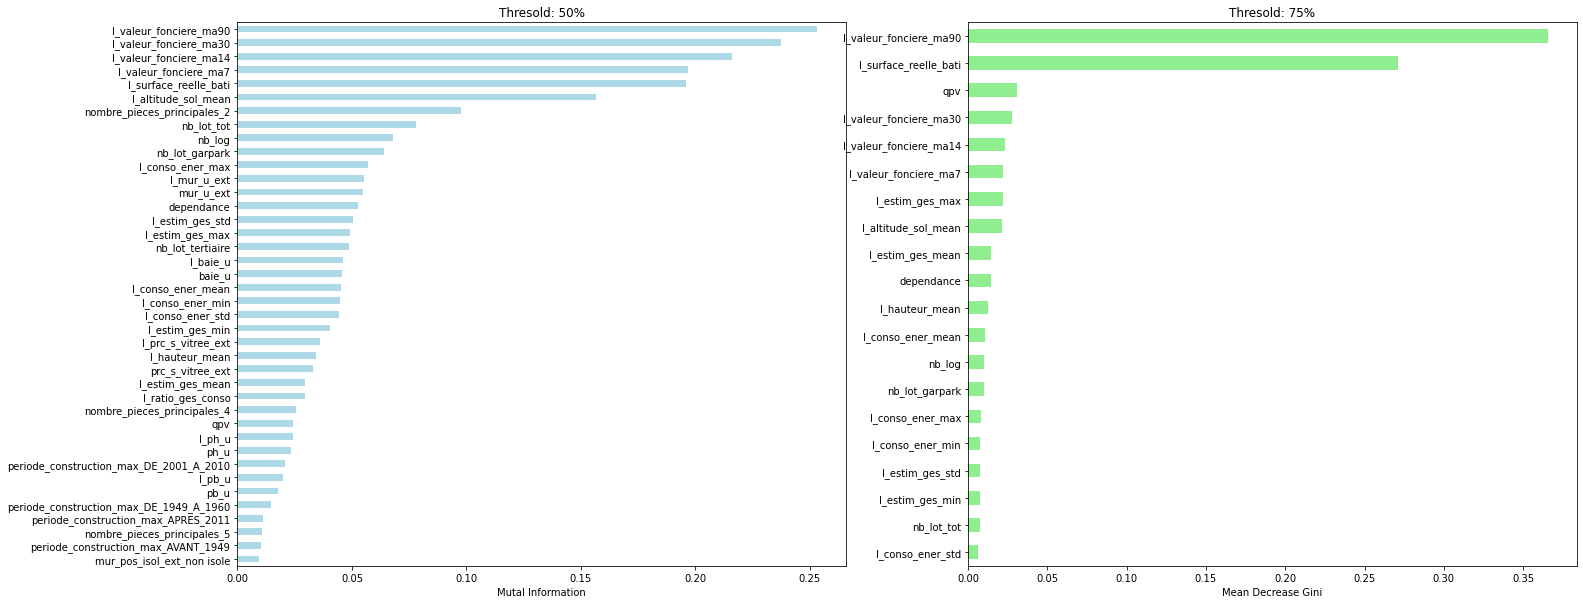

In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(24, 10))

mi_values[important_features_mi]\
    .sort_values()\
    .plot.barh(ax=axes[0], color="lightblue")

axes[0].set_xlabel("Mutal Information")
axes[0].set_title(f"Thresold: {mi_threshold}")

mdg_values[important_features_mdg]\
    .sort_values()\
    .plot.barh(ax=axes[1], color="lightgreen")

axes[1].set_xlabel("Mean Decrease Gini")
axes[1].set_title(f"Thresold: {mdg_threshold}"); 

In [39]:
important_features_mi = select_important_features(mi_values, threshold=.02) 

In [40]:
# get the union of the two sets of important features
selected_features = list(set(important_features_mi + important_features_mdg))

rich.print(f"{len(selected_features)} features sélectionnées")
rich.print(selected_features) 

34 features sélectionnées

[
    'prc_s_vitree_ext',
    'l_conso_ener_min',
    'nombre_pieces_principales_2',
    'nb_lot_garpark',
    'l_baie_u',
    'l_ph_u',
    'qpv',
    'l_conso_ener_mean',
    'l_mur_u_ext',
    'nb_lot_tertiaire',
    'l_valeur_fonciere_ma90',
    'l_hauteur_mean',
    'l_estim_ges_max',
    'l_conso_ener_max',
    'l_estim_ges_mean',
    'nombre_pieces_principales_4',
    'dependance',
    'l_valeur_fonciere_ma14',
    'ph_u',
    'l_valeur_fonciere_ma7',
    'l_estim_ges_min',
    'l_pb_u',
    'mur_u_ext',
    'l_prc_s_vitree_ext',
    'periode_construction_max_DE_2001_A_2010',
    'nb_lot_tot',
    'l_conso_ener_std',
    'baie_u',
    'l_surface_reelle_bati',
    'l_valeur_fonciere_ma30',
    'l_ratio_ges_conso',
    'l_estim_ges_std',
    'nb_log',
    'l_altitude_sol_mean'
]

In [43]:
X_tr_reduced = get_feature_vector(df_train, features=selected_features, return_df=False)
X_te_reduced = get_feature_vector(df_test, features=selected_features, return_df=False)

y_tr = get_target_vector(df_train, "l_valeur_fonciere", return_series=False) 
y_te = get_target_vector(df_test, "l_valeur_fonciere", return_series=False)

In [44]:
X_tr_reduced.shape

(15370, 34)

### Visualisation des features sélectionnées

In [34]:
numeric_features = [var for var in selected_features if is_numeric(df_preproc[var])]
category_features = [var for var in selected_features if var not in numeric_features] 

rich.print(f"Numeric features: {len(numeric_features)}")
rich.print(f"Dummy features: {len(category_features)}")

Numeric features: 20

Dummy features: 4

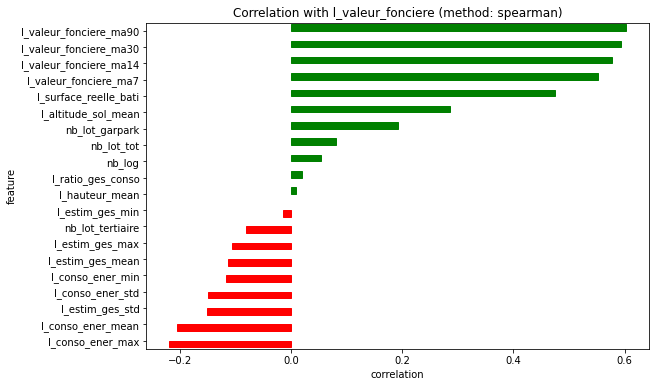

In [85]:
cor_method = "spearman"

cor = df_preproc[numeric_features + ["l_valeur_fonciere"]]\
    .corr(method=cor_method)["l_valeur_fonciere"]\
    .drop("l_valeur_fonciere")\
    .sort_values(ascending=False)\
    .reset_index()\
    .rename(columns={"index": "feature", "l_valeur_fonciere": "correlation"})

cor["sign"] = cor["correlation"].apply(lambda x: "+" if x > 0 else "-")

fig, ax = plt.subplots(figsize=(9, 6)) 

sns.barplot(data=cor, x="correlation", y="feature", orient="h", hue="sign", ax=ax)

for p in ax.patches:
    if p.get_width() > 0:
        p.set_color("green")
    else:
        p.set_color("red")

ax.legend([],[], frameon=False)
ax.set_title(f"Correlation with l_valeur_fonciere (method: {cor_method})"); 

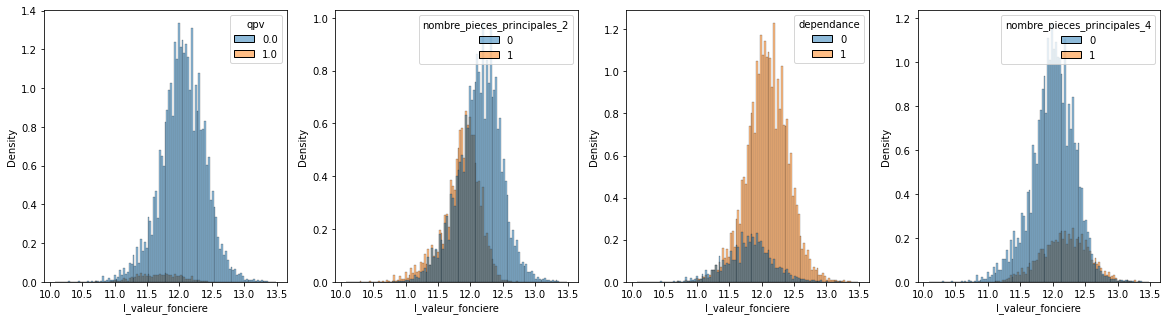

In [86]:
ncols = 4

if len(category_features) % ncols == 0:
    nrows = len(category_features) // ncols
else:
    nrows = len(category_features) // ncols + 1

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))

for var, ax in zip(category_features, axes.flatten()):
    sns.histplot(x="l_valeur_fonciere", hue=var, data=df_preproc, ax=ax, stat="density", alpha=.5); 

## Modèles de régression 

In [45]:
# indicate if we want to use the reduced feature matrix based on feature selection

use_selected_features = True 

if use_selected_features: 
    X_tr_, X_te_ = X_tr_reduced, X_te_reduced
else:
    X_tr_, X_te_ = X_tr, X_te

### Sans optimisation

L'objectif est d'entrainer plusieurs régresseurs pour déterminer le type de modèle qui semble le plus adapté pour estimer la relation entre `l_valeur_fonciere` et les features sélectionnées. 

Régresseurs :
- `DummyRegressor`, 
- `LinearRegression`, 
- `Ridge`, 
- `DecisionTreeRegressor`, 
- `RandomForestRegressor`, 
- `XGBRegressor`, 
- `MLPRegressor`. 

On garde les paramètres par défaut de chaque estimateur. 

In [159]:
estimators = [
    DummyRegressor(), 
    LinearRegression(),
    Ridge(),
    KNeighborsRegressor(n_neighbors=10),
    SVR(max_iter=2000),
    DecisionTreeRegressor(), 
    RandomForestRegressor(),
    XGBRegressor(), 
]

tree_based = ["DecisionTreeRegressor", "RandomForestRegressor", "XGBRegressor"]

results = {
    "train": {}, 
    "test": {}
}

models = {}

In [160]:
# scale feature matrix for non-tree based models

scaler = MinMaxScaler()

X_tr_scaled, scaler = scale_features(scaler, X_tr_, fit=True)
X_te_scaled = scale_features(scaler, X_te_)

In [63]:
loop = tqdm(estimators) 

for estimator in loop:

    model_name = estimator.__class__.__name__
    model = CustomRegressor(estimator)

    if model_name in tree_based:
        features_tr = X_tr_
        features_te = X_te_
    else: 
        model_name += " (scaled)"
        features_tr = X_tr_scaled
        features_te = X_te_scaled

    loop.set_description(f"Fitting {model_name}...")

    model.fit(features_tr, y_tr)

    models[model_name] = model

    metrics_train = compute_metrics(model, features_tr, y_tr, to_prices=True)
    metrics_test = compute_metrics(model, features_te, y_te, to_prices=True)

    results["train"][model_name] = metrics_train
    results["test"][model_name] = metrics_test

Fitting SVR (scaled)...:  50%|█████     | 4/8 [01:11<01:45, 26.49s/it]                c:\Users\pemma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Fitting XGBRegressor...: 100%|██████████| 8/8 [24:01<00:00, 180.18s/it]         


In [64]:
display_regression_report(results["train"], title="Metrics computed on valeur_fonciere (train set)")
display_regression_report(results["test"], title="Metrics computed on valeur_fonciere (test set)")

                       Metrics computed on valeur_fonciere (train set)                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Model                       ┃ MAE           ┃ % MAPE       ┃ MSE           ┃ % R²         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ DummyRegressor (scaled)     │ 270309.01     │ 64.08        │ 1.76e+11      │ -7.64        │
│ LinearRegression (scaled)   │ 91407.76      │ 20.48        │ 2.35e+10      │ 85.64        │
│ Ridge (scaled)              │ 91417.57      │ 20.48        │ 2.35e+10      │ 85.64        │
│ KNeighborsRegressor         │ 96323.33      │ 20.33        │ 2.67e+10      │ 83.66        │
│ (scaled)                    │               │              │               │              │
│ SVR (scaled)                │ 284307.77     │ 51.03        │ 1.38e+11      │ 15.71        │
│ DecisionTreeRegressor       │ 169.42        │ 0.04         │ 5.11e+07      │ 99.97        │
│ RandomForestRegressor       │ 33373.4       │ 6.9          │ 3.27e+09      │ 98.0         │
│ XGBRegressor                │ 76898.83      │ 17.27        │ 1.62e+10      │ 90.06        │
└─────────────────────────────┴───────────────┴──────────────┴───────────────┴──────────────┘

                       Metrics computed on valeur_fonciere (test set)                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Model                       ┃ MAE           ┃ % MAPE       ┃ MSE           ┃ % R²         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ DummyRegressor (scaled)     │ 289119.72     │ 58.33        │ 2.09e+11      │ -12.13       │
│ LinearRegression (scaled)   │ 92785.19      │ 18.79        │ 2.43e+10      │ 86.93        │
│ Ridge (scaled)              │ 92794.92      │ 18.79        │ 2.43e+10      │ 86.93        │
│ KNeighborsRegressor         │ 115383.57     │ 22.87        │ 3.74e+10      │ 79.93        │
│ (scaled)                    │               │              │               │              │
│ SVR (scaled)                │ 300662.54     │ 51.03        │ 1.53e+11      │ 17.82        │
│ DecisionTreeRegressor       │ 134291.12     │ 27.06        │ 4.79e+10      │ 74.3         │
│ RandomForestRegressor       │ 93317.06      │ 18.54        │ 2.49e+10      │ 86.63        │
│ XGBRegressor                │ 87536.55      │ 18.01        │ 2.26e+10      │ 87.85        │
└─────────────────────────────┴───────────────┴──────────────┴───────────────┴──────────────┘

In [170]:
best_model = models["XGBRegressor"]
best_model 

CustomRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       callbacks=None, colsample_bylevel=1,
                                       colsample_bynode=1, colsample_bytree=1,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=0, gpu_id=-1,
                                       grow_policy='depthwise',
                                       importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.300000012, max_bin=256,
                                       max_cat_threshold=64,
                                       max_cat_to_onehot=4, max_delta_step=0,
                                       max_depth=6, max_leaves=0,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=100, n_jobs=0,
                                       num_parallel_tree=1, predictor='auto',
                                       random_state=0, ...))

In [171]:
preds = get_predictions(best_model, X_te_, y_te)

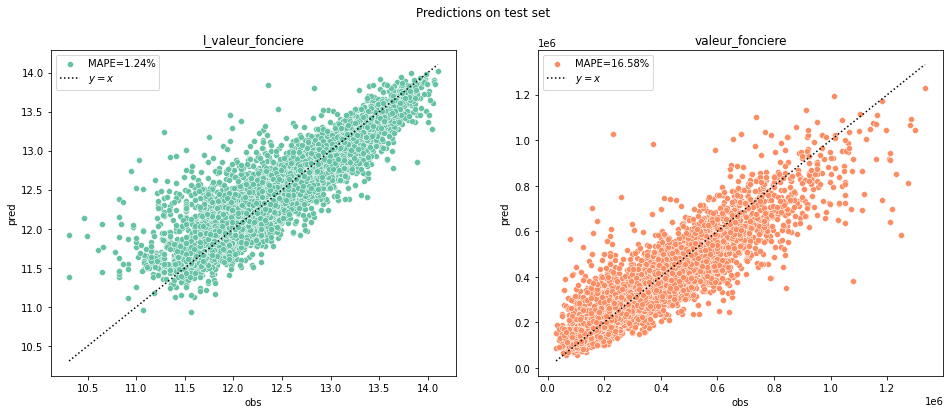

In [172]:
colors = sns.color_palette(palette="Set2", n_colors=2)

fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
fig.suptitle(f"Predictions on test set", fontsize=12)

for target, ax, color in zip(["l_valeur_fonciere", "valeur_fonciere"], axes.flatten(), colors):

    plot_predictions(
        y_true=preds[target]["y_true"],
        y_pred=preds[target]["y_pred"],
        color=color,
        title=target,
        ax=ax); 

### Optimisation via `optuna`

`optuna` est un framework python permerttant de trouver les paramètres maximisant (ou minimisant) une fonction objectif. `optuna` utilise un historique des essais pour déterminer les valeurs d'hyperparamètres à essayer pour les prochains essais. À l'aide de ces données, il estime les zones les plus prometteuses pour atteindre l'objectif et essaie des valeurs dans cette zone. `optuna` estime ensuite une région encore plus prometteuse sur la base du nouveau résultat, et ainsi de suite jusqu'à convergence de la fonction cible. 

Pour afficher le dashboard résumant l'optimisation : 

```
optuna-dashboard sqlite:///./backup/__optuna/db.sqlite3

Listening on http://localhost:8080/
Hit Ctrl-C to quit.
```

#### Instantiation study `optuna`

In [46]:
pruner = OptimPruner(n_warmup_trials=5, n_trials_to_prune=10)

version = 0

if df_args["departement"] is not None:
    study_name = f"optim-{df_args['departement']}-{df_args['property_type']}-xgb-v{version}".lower()
elif df_args["region"] is not None:
    df_args["region"] = f"optim-{df_args['region']}-{df_args['property_type']}-xgb-v{version}".lower()
else:
    study_name = f"optim-{df_args['geo_area']}-{df_args['property_type']}-xgb-v{version}".lower()

optuna_args = {
    "storage": f"sqlite:///{BACKUP_DIR}__optuna/db.sqlite3", 
    "study_name": study_name, 
    "pruner": pruner
}

rich.print(optuna_args)

{
    'storage': 'sqlite:///../backup/__optuna/db.sqlite3',
    'study_name': 'optim-seine-et-marne-flats-xgb-v0',
    'pruner': OptimPruner(n_warmup_trials=5, n_trials_to_prune=10)
}

In [47]:
try: 
    study = optuna.create_study(direction="minimize", **optuna_args)
except:
    study = optuna.load_study(**optuna_args)

In [90]:
# get all studies in the database
all_studies = optuna.get_all_study_summaries(storage=optuna_args["storage"])

# display name of all studies   
rich.print([study.study_name for study in all_studies])

[
    'optim-paris-flats-xgb-v0',
    'optim-paris-flats-xgb-v1',
    'optim-paris-flats-xgb-v2',
    'optim-marseille-flats-xgb-v0',
    'optim-hauts-de-seine-flats-xgb-v0',
    'optim-val-de-marne-flats-xgb-v0',
    'optim-val-de-marne-flats-xgb-v3',
    'optim-paris-flats-xgb-v3',
    'optim-seine-saint-denis-flats-xgb-v3',
    'optim-yvelines-flats-xgb-v0',
    'optim-essonne-flats-xgb-v0',
    "optim-val-d'oise-flats-xgb-v0",
    'optim-seine-et-marne-flats-xgb-v0',
    'optim-paris-flats-xgb-v4'
]

#### Recherche modèle optimal

In [50]:
regressor = CustomRegressor(estimator=XGBRegressor())

optim_args = {
    "regressor": regressor,
    "X_tr": X_tr_,
    "y_tr": y_tr,
    "X_te": X_te_,
    "y_te": y_te, 
    "to_prices": False
}

In [61]:
study.optimize(
    func=lambda trial: optuna_objective(trial, **optim_args),
    n_trials=20,
    n_jobs=CPU_COUNT/2,
    show_progress_bar=True
)

In [40]:
rich.print(study.best_trial) 

FrozenTrial(number=46, values=[0.010522606565415454], datetime_start=datetime.datetime(2023, 
4, 5, 21, 54, 12, 445045), datetime_complete=datetime.datetime(2023, 4, 5, 21, 56, 14, 
498457), params={'learning_rate': 0.012624259374338425, 'max_depth': 9, 'n_estimators': 822, 
'reg_alpha': 0.2344713662452573, 'reg_lambda': 0.002286505978657769, 'subsample': 
0.7401398701277477}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, 
low=0.001, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 
'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'reg_alpha': 
FloatDistribution(high=1000.0, log=True, low=0.001, step=None), 'reg_lambda': 
FloatDistribution(high=1000.0, log=True, low=0.001, step=None), 'subsample': 
FloatDistribution(high=1.0, log=True, low=0.5, step=None)}, user_attrs={}, system_attrs={}, 
intermediate_values={}, trial_id=391, state=TrialState.COMPLETE, value=None)

#### Entrainement `XGBRegressor`

Utilisation des hyperparamètres optimaux pour entrainer `XGBRegressor`. 

In [41]:
params_opt = study.best_params
rich.print(params_opt)

xgb_opt = CustomRegressor(estimator=XGBRegressor(**params_opt))

{
    'learning_rate': 0.012624259374338425,
    'max_depth': 9,
    'n_estimators': 822,
    'reg_alpha': 0.2344713662452573,
    'reg_lambda': 0.002286505978657769,
    'subsample': 0.7401398701277477
}

In [42]:
xgb_opt.fit(X_tr_, y_tr)

CustomRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       callbacks=None, colsample_bylevel=1,
                                       colsample_bynode=1, colsample_bytree=1,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=0, gpu_id=-1,
                                       grow_policy='depthwise',
                                       importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.012624259374338425,
                                       max_bin=256, max_cat_threshold=64,
                                       max_cat_to_onehot=4, max_delta_step=0,
                                       max_depth=9, max_leaves=0,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=822, n_jobs=0,
                                       num_parallel_tree=1, predictor='auto',
                                       random_state=0, ...))

#### Diganostic modèle optimal

In [43]:
xgb_opt_metrics = {
    "train": {"XGBRegressor": compute_metrics(xgb_opt, X_tr_, y_tr)}, 
    "test": {"XGBRegressor": compute_metrics(xgb_opt, X_te_, y_te)}
}

In [44]:
display_regression_report(xgb_opt_metrics["train"], title="Fine-tuned XGBRegressor metrics (train set)")
display_regression_report(xgb_opt_metrics["test"], title="Fine-tuned XGBRegressor metrics (test set)")

                         Fine-tuned XGBRegressor metrics (train set)                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Model                       ┃ MAE           ┃ % MAPE       ┃ MSE           ┃ % R²         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ XGBRegressor                │ 16035.75      │ 9.06         │ 5.39e+08      │ 86.59        │
└─────────────────────────────┴───────────────┴──────────────┴───────────────┴──────────────┘

                         Fine-tuned XGBRegressor metrics (test set)                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Model                       ┃ MAE           ┃ % MAPE       ┃ MSE           ┃ % R²         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ XGBRegressor                │ 25336.89      │ 13.37        │ 1.31e+09      │ 72.31        │
└─────────────────────────────┴───────────────┴──────────────┴───────────────┴──────────────┘

In [45]:
xgb_preds = {
    "train": get_predictions(xgb_opt, X_tr_, y_tr), 
    "test": get_predictions(xgb_opt, X_te_, y_te)
}

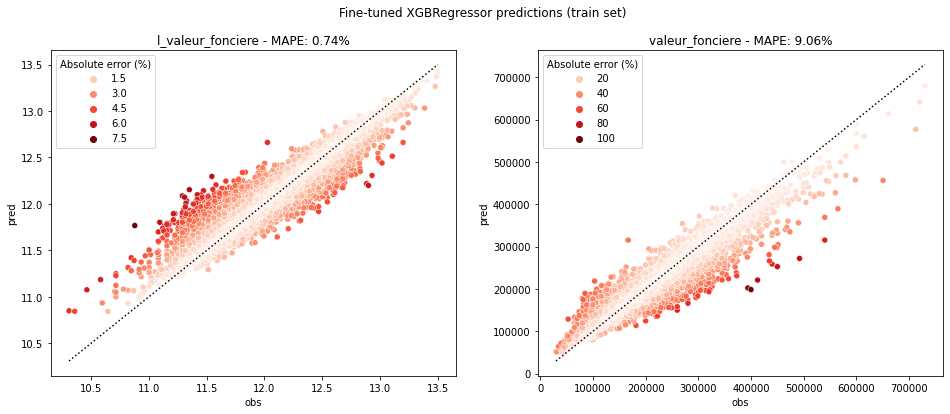

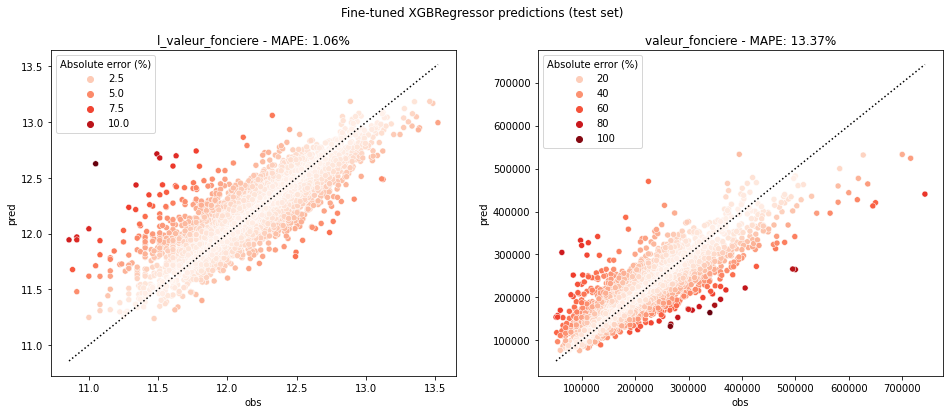

In [46]:
for dataset, preds in xgb_preds.items():

    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

    title = f"Fine-tuned XGBRegressor predictions ({dataset} set)"
    fig.suptitle(title, fontsize=12)

    for target, ax in zip(["l_valeur_fonciere", "valeur_fonciere"], axes.flatten()):

        plot_predictions(
            y_true=preds[target]["y_true"],
            y_pred=preds[target]["y_pred"],
            title=target,
            ax=ax);

### Entrainement sur dataset complet

In [47]:
# concatenate train and test sets to retrain model 

X = np.concatenate([X_tr_, X_te_])
y = np.concatenate([y_tr, y_te])

assert X.shape[0] == y.shape[0]

In [48]:
xgb_opt.fit(X, y)

CustomRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       callbacks=None, colsample_bylevel=1,
                                       colsample_bynode=1, colsample_bytree=1,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=0, gpu_id=-1,
                                       grow_policy='depthwise',
                                       importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.012624259374338425,
                                       max_bin=256, max_cat_threshold=64,
                                       max_cat_to_onehot=4, max_delta_step=0,
                                       max_depth=9, max_leaves=0,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=822, n_jobs=0,
                                       num_parallel_tree=1, predictor='auto',
                                       random_state=0, ...))

In [49]:
xgb_opt_metrics["all"] = {"XGBRegressor": compute_metrics(xgb_opt, X_te_, y_te)}

In [50]:
display_regression_report(xgb_opt_metrics["all"], title="Fine-tuned XGBRegressor metrics (all)")

                            Fine-tuned XGBRegressor metrics (all)                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Model                       ┃ MAE           ┃ % MAPE       ┃ MSE           ┃ % R²         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ XGBRegressor                │ 18401.01      │ 9.63         │ 6.72e+08      │ 85.74        │
└─────────────────────────────┴───────────────┴──────────────┴───────────────┴──────────────┘

### Sauvegarde

In [51]:
if use_selected_features: 
    feature_names = selected_features
else:
    feature_names = features

if df_args["departement"] is not None:
    geo_area = df_args["departement"]
elif df_args["region"] is not None:
    geo_area = df_args["region"]
else:
    geo_area = df_args["geo_area"]

backup_args = {
    "version": 0, 
    "geo_area": geo_area, 
    "property_type": df_args["property_type"]
}

backup_args

{'version': 0, 'geo_area': "Val-d'Oise", 'property_type': 'flats'}

In [52]:
save_model(
    path=f"{BACKUP_DIR}models",
    model=xgb_opt, 
    feature_names=feature_names, 
    metrics=xgb_opt_metrics, 
    **backup_args)

XGBRegressor and feature names saved at ../backup/models/xgbregressor-val-d'oise-flats-v0.pkl


In [77]:
# load best model and feature names as dict 

xgb_loader = load_model(
    path=f"{BACKUP_DIR}models",
    estimator_name="XGBRegressor", 
    **backup_args)

Succesfully loaded XGBRegressor, feature names and metrics from ../backup/models/xgbregressor-yvelines-flats-v0.pkl.


In [78]:
xgb_opt = xgb_loader["model"]

feature_names = xgb_loader["feature_names"]
rich.print(f"Features used to fit model:\n{feature_names}")

metrics = xgb_loader["metrics"]
rich.print(metrics)

Features used to fit model:
['l_surface_reelle_bati', 'l_altitude_sol_mean', 'nb_log', 'l_estim_ges_mean', 'nb_lot_garpark', 'l_estim_ges_max',
'l_estim_ges_std', 'l_valeur_fonciere_ma30', 'l_valeur_fonciere_ma7', 'l_valeur_fonciere_ma14', 
'nombre_pieces_principales_1', 'l_conso_ener_min', 'l_hauteur_mean', 'l_conso_ener_mean', 'l_valeur_fonciere_ma90',
'l_estim_ges_min', 'nb_lot_tot', 'l_conso_ener_std', 'l_conso_ener_max', 'nb_lot_tertiaire']

{
    'train': {
        'XGBRegressor': {
            'mean_absolute_error': 26602.58486493745,
            'mean_absolute_percentage_error': 0.11050032898535606,
            'mean_squared_error': 1741599939.2233443,
            'r2_score': 0.923576299607247
        }
    },
    'test': {
        'XGBRegressor': {
            'mean_absolute_error': 39552.05435132941,
            'mean_absolute_percentage_error': 0.1464590128666956,
            'mean_squared_error': 4309478356.404163,
            'r2_score': 0.834698646981437
        }
    },
    'all': {
        'XGBRegressor': {
            'mean_absolute_error': 28868.53709388418,
            'mean_absolute_percentage_error': 0.11254958258555264,
            'mean_squared_error': 1948233887.8504567,
            'r2_score': 0.9252703758960258
        }
    }
}